In [784]:
import pandas as pd
import numpy as np
import sys
import jsonpickle as jp
import matplotlib.pyplot as plt
import logging

sys.path.append(r"/Users/ysc/Desktop/imcProsperity/utils")

pd.options.mode.chained_assignment = None


In [785]:
from dataclasses import dataclass
from collections import defaultdict


POSITION_LIMIT = {
    'AMETHYSTS': 20,
    'STARFRUIT': 20
}


@dataclass
class result:
    """Class for simulation result"""
    import logging
    logging.basicConfig(format='%(message)s', level=logging.INFO)

    pnl: defaultdict
    transactions: pd.DataFrame
    mid_price: defaultdict
    position: defaultdict

    def summary(self, verbose=False):

        product_list = list(self.pnl.keys())
        product_list.remove('total')

        for k, v in self.pnl.items():
            logging.info(f" -> {k}: {v[-1]:.1f}")
        
        logging.info('\n')

        total_transaction_amt = len(self.transactions)        
        logging.info(f"# of transaction is {total_transaction_amt:d}")
        for k in product_list:
            buy = self.transactions[(self.transactions['Product'] == k) & (self.transactions['B/S'] == 'B')]
            sell = self.transactions[(self.transactions['Product'] == k) & (self.transactions['B/S'] == 'S')]
            total_v = len(buy) + len(sell)
            logging.info(f" -> {k}: B({len(buy):>3d}) + S({len(sell):>3d})")

        if not verbose:
            fig, ax = plt.subplots(1, 1)
            legends = []
            for k, v in self.pnl.items():
                ax.set_title("PnL")
                ax.plot(v)
                legends.append(k)
            ax.legend(legends)

        else:
            nrow = len(self.pnl) - 1
            fig, axs = plt.subplots(nrow, 2, figsize=(20, 12))
            for i, (k, v) in enumerate(self.pnl.items()):
                if k != 'total':
                    axs[i][0].set_title(k)
                    axs[i][0].plot(v)   
                    axs[i][0].legend(["Pnl"])
              
                    axs[i][1].set_title(k)
                    axs[i][1].plot(self.position[k])
                    ax2 = axs[i][1].twinx()
                    ax2.plot(self.mid_price[k], c='orange', alpha=0.5)
                    axs[i][1].set_ylim([-POSITION_LIMIT[k], POSITION_LIMIT[k]])


class Simulator:

    def __init__(self, scenario_path=None, df=None):

        if df is not None:
            self.df = df
        elif scenario_path is not None:
            self.df = pd.read_csv(scenario_path, sep=';')
    
        self.product = self.df['product'].unique().tolist()
        self.last_price_ = defaultdict(list)

        self.traderdata = ""
        self.timestamp = sorted(self.df['timestamp'].unique())
        self.order_depths_ = dict()
        self.own_trades_ = dict()
        self.listings_ = dict()
        self.market_trades_ = dict()
        self.position_ = defaultdict(lambda: [0])
        self.observations_ = dict() 
        self.pnl_ = defaultdict(lambda: [0])
        self.cost_basis_ = defaultdict(float)
        self.records = pd.DataFrame(columns=['TimeStamp', 'B/S', 'Quantity', "Product", 'Price'])


    def _clear(self):
        self.order_depths_.clear()
        self.own_trades_.clear()
        self.listings_.clear()
        self.market_trades_.clear()
        self.observations_.clear() 


    def _breach_or_not(self):
        for k, v in POSITION_LIMIT.items():
            if abs(self.position_[k][-1]) > v:
                return True
        return False


    def _settle(self, orders, timestamp):

        for product in self.product:
            
            new_position = self.position_[product][-1]

            if product in orders:
                
                order_depth = self.order_depths_[product]
                order = orders[product]

                sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
                sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)

                for o in order:
                    price, quantity = o.price, o.quantity

                    if quantity > 0:
                        for p, vol in sorted_sell_orders:
                            p, vol = int(p), int(vol)
                            if p <= price and quantity > 0:
                                done = min(quantity, abs(vol))
                                quantity -= done
                                new_position += done 
                                if product not in self.own_trades_:
                                    self.own_trades_[product] = [datamodel.Trade(product, p, done, self.traderdata, "", timestamp)]
                                else:
                                    self.own_trades_[product].append(datamodel.Trade(product, p, done, self.traderdata, "", timestamp))

                                self.cost_basis_[product] -= done * p

                                self.records.loc[len(self.records)] = timestamp, 'B', done, product, p

                    elif quantity < 0:
                        for p, vol in sorted_buy_orders:
                            p, vol = int(p), int(vol)
                            if p >= price and quantity < 0:
                                done = min(abs(quantity), vol)
                                quantity += done
                                new_position -= done 
                                if product not in self.own_trades_:
                                    self.own_trades_[product] = [datamodel.Trade(product, p, -done, "", self.traderdata, timestamp)]
                                else:
                                    self.own_trades_[product].append(datamodel.Trade(product, p, -done, "", self.traderdata, timestamp))

                                self.cost_basis_[product] += done * p
                                self.records.loc[len(self.records)] = timestamp, 'S', done, product, p
            
            self.position_[product] += [new_position]
            self.pnl_[product] += [ self.cost_basis_[product] + self.last_price_[product][-1] * self.position_[product][-1] ]

        self.pnl_['total'] += [ sum(self.pnl_[product][-1] for product in self.product) ]


    def simulate(self, Trader):

        for timestamp_ in self.timestamp:
            
            self._clear()

            tmp = self.df[self.df['timestamp'] == timestamp_]
            for _, row in tmp.iterrows():

                product_ = row['product']
                self.last_price_[product_] += [row['mid_price']]

                self.listings_[product_] = datamodel.Listing(product_, product_, 'SEASHELLS')
                self.order_depths_[product_] = datamodel.OrderDepth()

                dict_ = dict()
                for i in (1, 2, 3):
                    if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
                        dict_[row[f'bid_price_{i}']] = row[f'bid_volume_{i}']
                self.order_depths_[product_].buy_orders = dict_
                
                dict_ = dict()
                for i in (1, 2, 3):
                    if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
                        dict_[row[f'ask_price_{i}']] = -row[f'ask_volume_{i}']
                self.order_depths_[product_].sell_orders = dict_

            position__ = {k: v[-1] for k, v in self.position_.items()}

            tradingstate_ = datamodel.TradingState("", timestamp_, self.listings_, self.order_depths_, self.own_trades_, self.market_trades_, position__, self.observations_)

            orders, _, name = Trader.run(tradingstate_)

            self._settle(orders, timestamp_)

            if self._breach_or_not():
                return f"Breach Occurs at timestamp {timestamp_}"
        
        return result(self.pnl_, self.records, self.last_price_, self.position_)

In [786]:
import datamodel
from datamodel import OrderDepth, UserId, TradingState, Order

class Trader:

    LIMIT = {
        'AMETHYSTS': 20,
        'STARFRUIT': 20
    }

    starfruit_price_history = []
    starfruit_initial_price = 5000
    ma_window_size = 10
    positive_cnt = []

    @staticmethod
    def calculate_wavg_midprice(order_depth):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        total_volume = 0
        wavg_price = 0
        for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
        wavg_price /= total_volume
        return wavg_price

    @staticmethod
    def calculate_barrier_price(order_depth, barrier=10):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        buy_p_, sell_p_ = -1, -1
        buy_vol_, sell_vol_ = 0, 0
        for p, vol in sorted_buy_orders:
            if vol >= barrier:
                buy_p_, buy_vol_ = p, vol
                break
            elif vol > buy_vol_:
                buy_p_, buy_vol_ = p, vol
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            if vol >= barrier:
                sell_p_, sell_vol_ = p, vol
                break
            elif vol > sell_vol_:
                sell_p_, sell_vol_ = p, vol
        return buy_p_, sell_p_

    @staticmethod
    def hit_the_book(product, order_depth, buy_capacity, buy_price, sell_capacity, sell_price):
        sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
        sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
        orders = []
        for p, vol in sorted_buy_orders:
            vol = abs(vol)
            if p >= sell_price:
                s_amt = min(sell_capacity, vol)
                if s_amt > 0:
                    sell_capacity -= s_amt
                    orders.append(Order(product, p, -s_amt))
        for p, vol in sorted_sell_orders:
            vol = abs(vol)
            if p <= buy_price:
                b_amt = min(buy_capacity, vol)
                if b_amt > 0:
                    buy_capacity -= b_amt
                    orders.append(Order(product, p, b_amt))
        return orders, buy_capacity, sell_capacity

    def run(self, state):

        result = {}
        idx = state.timestamp // 100

        for product in state.order_depths:

            current_position = state.position.get(product, 0)
            order_depth = state.order_depths[product]
            orders = []

            if product == "AMETHYSTS":

                sell_capacity = - self.LIMIT[product] - current_position
                buy_capacity = self.LIMIT[product] - current_position

                if sell_capacity < 0:
                    orders.append(Order(product, 10001, sell_capacity))
                if buy_capacity > 0:
                    orders.append(Order(product, 9999, buy_capacity))

            elif product == "STARFRUIT":

                wavg_price = self.calculate_wavg_midprice(order_depth)

                sell_capacity = self.LIMIT[product] + current_position
                buy_capacity = self.LIMIT[product] - current_position
                _orders, buy_capacity, sell_capacity = self.hit_the_book(product, order_depth,
                                                                         buy_capacity, wavg_price - 0.5,
                                                                         sell_capacity, wavg_price + 0.5)
                orders.extend(_orders)

                if sell_capacity <= 10:
                    sell_margin, buy_margin = 1, 0
                elif buy_capacity <= 10:
                    sell_margin, buy_margin = 0, 1
                else:
                    sell_margin, buy_margin = 1, 1

                wavg_price = int(round(wavg_price, 0))
                if sell_capacity > 0:
                    orders.append(Order(product, wavg_price + sell_margin, -sell_capacity))
                if buy_capacity > 0:
                    orders.append(Order(product, wavg_price - buy_margin, buy_capacity))

            result[product] = orders

        return result, None, "Taeja"

 -> AMETHYSTS: 7500.0
 -> STARFRUIT: 10197.0
 -> total: 17697.0


# of transaction is 4235
 -> AMETHYSTS: B(789) + S(780)
 -> STARFRUIT: B(1067) + S(1599)


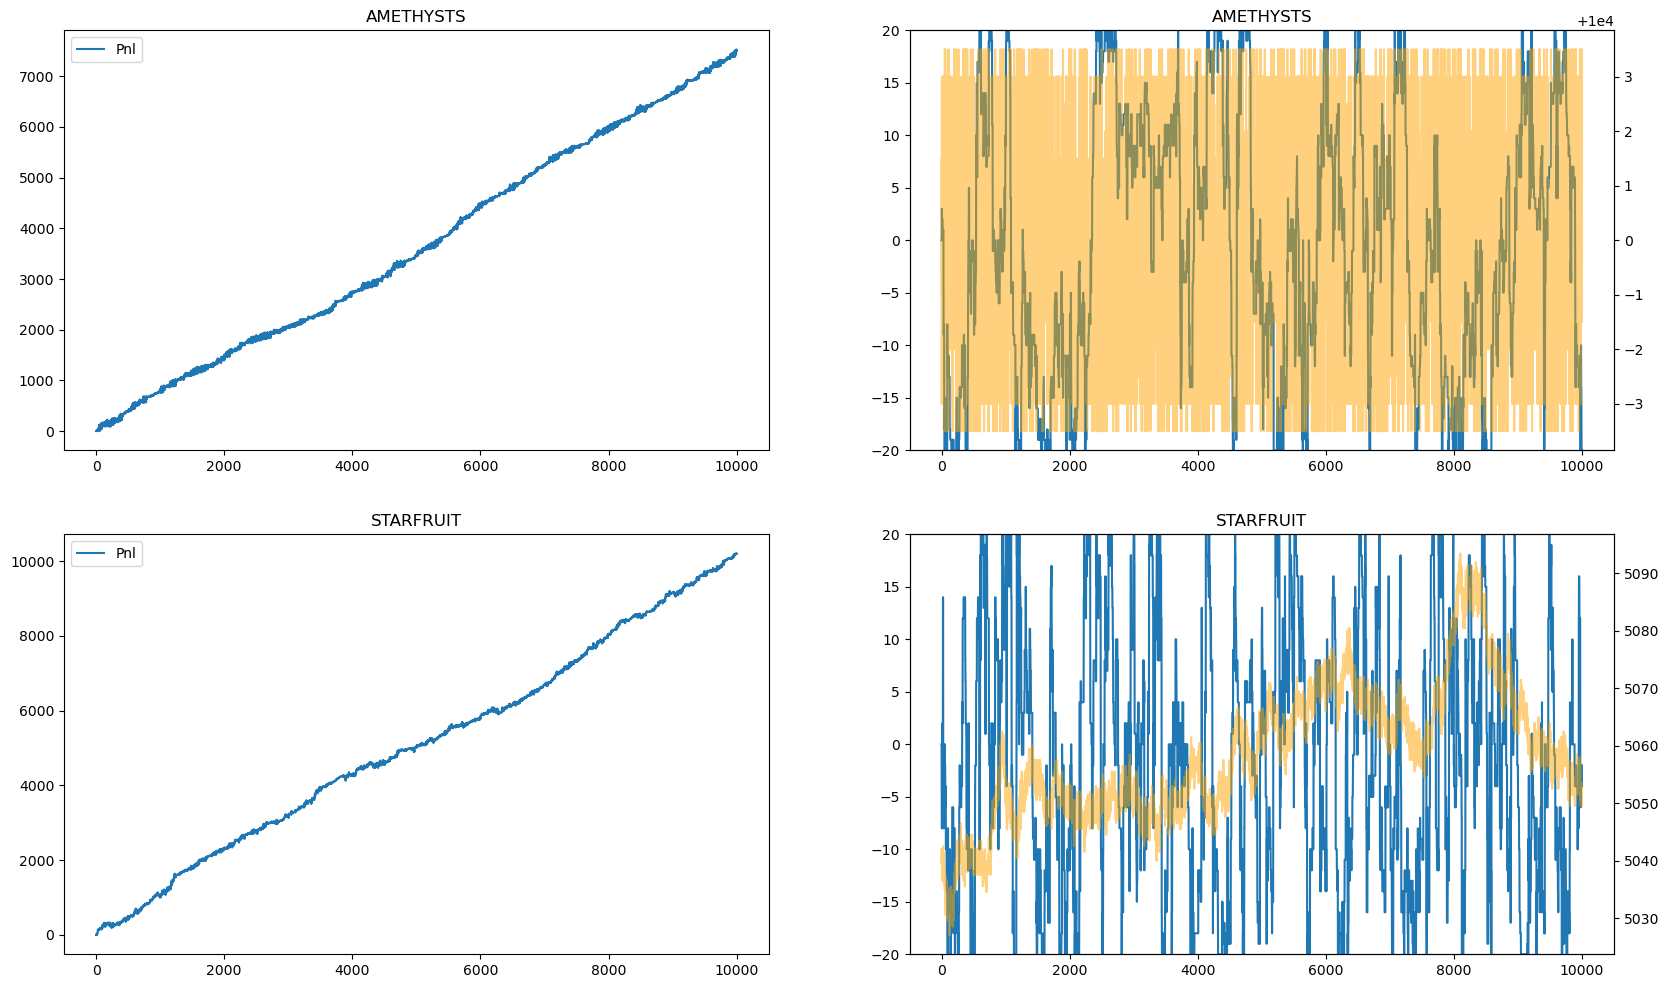

In [787]:
day = 0
# simulator = Simulator(rf"/Users/ysc/Desktop/imcProsperity/round1/data/prices_round_1_day_{day}.csv")
df = pd.read_csv(rf"/Users/ysc/Desktop/imcProsperity/round1/data/prices_round_1_day_{day}.csv", sep=';')[:20000]
simulator = Simulator(df=df)
trader1 = Trader()
res = simulator.simulate(trader1)
res.summary(verbose=True)

(array([ 454.,  699.,    0., 1351.,    0.,   35.,    0., 1290.,    0.,
        1077.]),
 array([ 9995.,  9996.,  9997.,  9998.,  9999., 10000., 10001., 10002.,
        10003., 10004., 10005.]),
 <BarContainer object of 10 artists>)

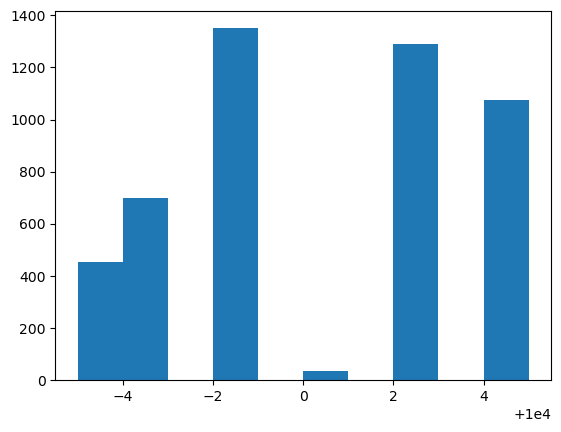

In [788]:
day = 0
product = "AMETHYSTS"

df = pd.read_csv(rf"/Users/ysc/Desktop/imcProsperity/round1/data/trades_round_1_day_{day}_nn.csv", sep=';')
df = df[df['symbol'] == product]
df.reset_index(inplace=True)

plt.hist(df['price'].values, weights=df['quantity'].values)

Total transactions: 376; Mine: 263


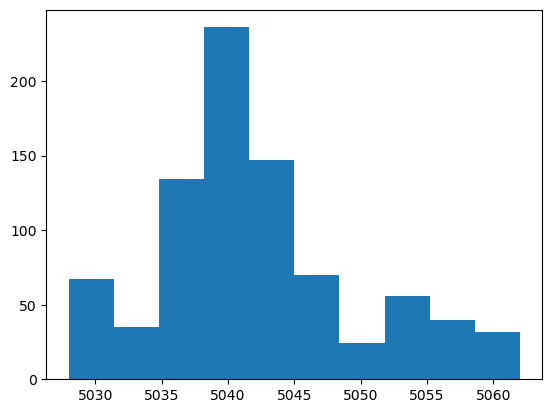

In [822]:
product = "STARFRUIT"
filepath = r"/Users/ysc/Downloads/c504d184-5ce4-4889-8980-d727163579c3.log"

class tradelog:
    
    def __init__(self, log):
        self._dict = log
    
    def __getattr__(self, w):
        return self._dict.get(w, "")

with open(filepath) as f:
    o = f.read()
    start = o.find("Trade History:\n")   
    o = o[start+15:]  
    log_ = jp.decode(o)

log = []
for l in log_:
    log.append( tradelog(l) )

D_buy, D_sell = defaultdict(list), defaultdict(list)
for l in log:
    if l.symbol == product:
        if l.seller == "SUBMISSION":
            D_sell[l.timestamp // 100].append([l.price, l.quantity])
        elif l.buyer == "SUBMISSION":
            D_buy[l.timestamp // 100].append([l.price, l.quantity])

p, q = [], []
tot = cnt = 0
for l in log:
    if l.symbol == product:
        tot += 1
        if l.seller == "SUBMISSION" or l.buyer == "SUBMISSION":
            cnt += 1
            p += [l.price]
            q += [l.quantity] 

print(f"Total transactions: {tot}; Mine: {cnt}")
_ = plt.hist(p, weights=q)

{5043: -22}


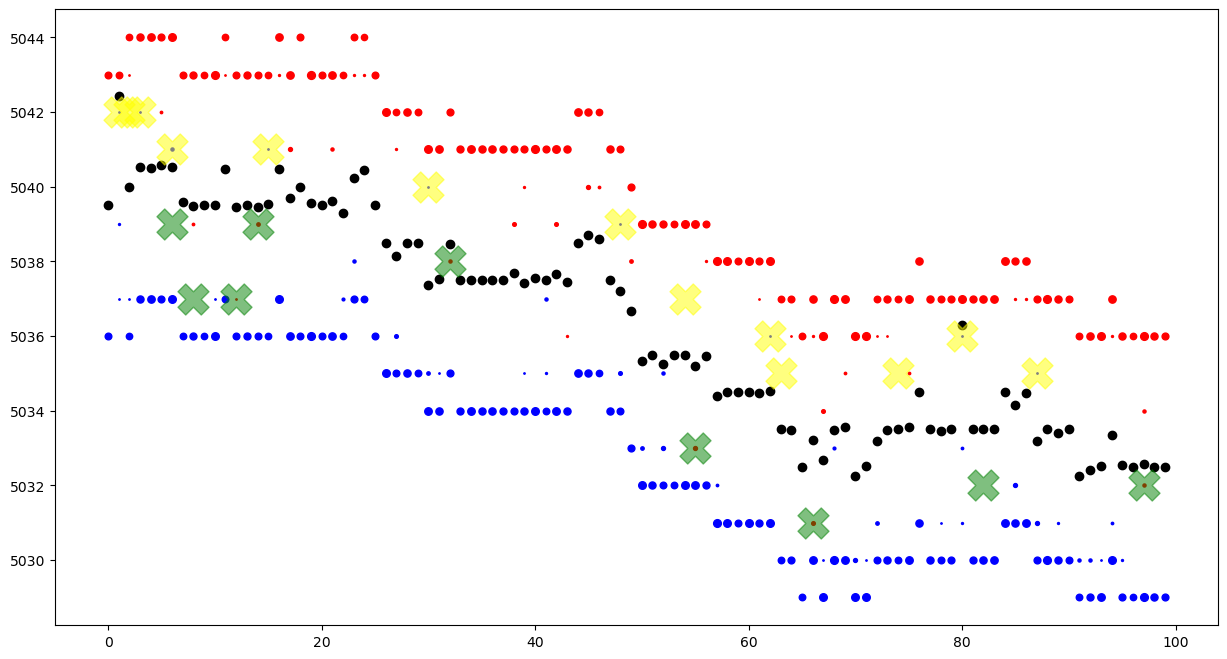

In [817]:
N = 100


class OrderDepth:
      def __init__(self):
            self.buy_orders = None
            self.sell_orders = None

def calculate_wavg_midprice(order_depth):
      sorted_buy_orders = sorted(order_depth.buy_orders.items(), reverse=True)
      sorted_sell_orders = sorted(order_depth.sell_orders.items(), reverse=False)
      total_volume = 0
      wavg_price = 0
      for p, vol in sorted_buy_orders:
            wavg_price += p * vol
            total_volume += vol
      for p, vol in sorted_sell_orders:
            vol = abs(vol)
            wavg_price += p * vol
            total_volume += vol
      wavg_price /= total_volume
      return wavg_price


with open(filepath) as f:
    o = f.read()
    start = o.find("\n\n\n")
    o = o[start+20:]
    end = o.find("\n\n\n") 
    o = o[:end]

with open("/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", mode='w') as f:
    f.write(o)

df = pd.read_csv(r"/Users/ysc/Desktop/imcProsperity/utils/__tmp__.csv", sep=';')
df = df[df['product'] == product]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15, 8))
order_depth_ = OrderDepth()

for _, row in df[:N].iterrows():
      idx = row['timestamp'] // 100
      if idx > N:
            break
      dict_ = dict()
      for i in (1, 2, 3):
              if row[f'bid_volume_{i}'] != 0 and not np.isnan(row[f'bid_volume_{i}']):
                  ax.scatter(idx, row[f'bid_price_{i}'], c='blue', s=row[f'bid_volume_{i}'])
                  dict_[row[f'bid_price_{i}']] = row[f'bid_volume_{i}']
      order_depth_.buy_orders = dict_

      dict_ = dict()

      for i in (1, 2, 3):
            if row[f'ask_volume_{i}'] != 0 and not np.isnan(row[f'ask_volume_{i}']):
                  ax.scatter(idx, row[f'ask_price_{i}'], c='red', s=row[f'ask_volume_{i}'])
                  dict_[row[f'ask_price_{i}']] = -row[f'ask_volume_{i}']
      if idx == 1:
            print(dict_)
      order_depth_.sell_orders = dict_

      ax.scatter(idx, calculate_wavg_midprice(order_depth_), c='black')


for k, (p, q) in D_sell.items():
      if k <= N:
            ax.scatter(k, p, c='yellow', marker='X', alpha=0.5, s=500)

for k, (p, q) in D_buy.items():
      if k <= N:
            ax.scatter(k, p, c='green', marker='X', alpha=0.5, s=500)

print(len())

In [806]:
o[end-100:end]

'7;10004;1;10005;27;;;10001.0;1522.0\n0;99900;STARFRUIT;5050;28;;;;;5051;1;5057;28;;;5050.5;-1429.5625'